# Figure 7: Genetics analysis of ClinVar database

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import preprocessing, sequence, model_builder, classification_cleavage, motifs, relative_strength, genomic_context, genetics

import vcf


In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"
CLINDIR = os.path.join(PROJECT, 'genetics', 'clinvar_NEW')
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_07", "clinvar")
os.makedirs(OUTDIR, exist_ok = True)


## IMPORT DATA

In [6]:
with open(os.path.join(RESDIR, "clinvar.representative_sites.pickle"), mode = 'rb') as handle:
    clin_repr = pickle.load(handle)
    
print(clin_repr.shape)
    
clin_repr = clin_repr.loc[clin_repr['referenceFeature'] == clin_repr['alternateFeature']].copy()
clin_repr_xte = clin_repr.loc[clin_repr['referenceFeature'].str.contains("terminal_exon")].copy()
clin_repr_int = clin_repr.loc[clin_repr['referenceFeature'].str.contains("intron")].copy()

print(clin_repr.shape)
print(clin_repr_xte.shape)
print(clin_repr_int.shape)


(85738, 46)
(85599, 46)
(19827, 46)
(60888, 46)


In [7]:
print("\n### Extended/terminal exonic:")
print(f"Number of variant-pA test sites             {clin_repr_xte.shape[0]:6}")
print(f"Number of unique variants                   {clin_repr_xte.variantID.nunique():6}")
print(f"Number of variants evaluated more than once {(clin_repr_xte.variantID.value_counts() > 1).sum():6}")

print("\n### Intronic:")
print(f"Number of variant-pA test sites             {clin_repr_int.shape[0]:6}")
print(f"Number of unique variants                   {clin_repr_int.variantID.nunique():6}")
print(f"Number of variants evaluated more than once {(clin_repr_int.variantID.value_counts() > 1).sum():6}")



### Extended/terminal exonic:
Number of variant-pA test sites              19827
Number of unique variants                    18753
Number of variants evaluated more than once    928

### Intronic:
Number of variant-pA test sites              60888
Number of unique variants                    59081
Number of variants evaluated more than once   1649


#### Filter representative test sites that have a significant effect on either PolyaID classification or PolyaStrength predictions

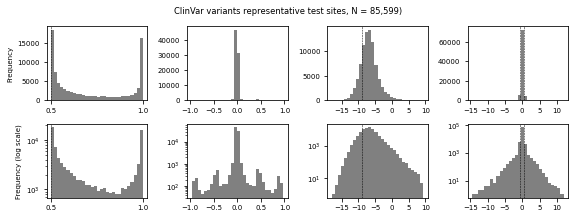

In [8]:
fig,ax = plt.subplots(2,4, figsize = (8,3))
ax = ax.T

for a in ax[0]:
    a.hist(clin_repr[['referenceClassprob','alternateClassprob']].max(axis = 1), color = 'gray', bins = 30)
    a.axvline(x = 0.5, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(0.5))

for a in ax[1]:
    a.hist(clin_repr['deltaClassification'], color = 'gray', bins = 30)
    a.xaxis.set_major_locator(MultipleLocator(0.5))

for a in ax[2]:
    a.hist(clin_repr[['referenceStrength','alternateStrength']].max(axis = 1), color = 'gray', bins = 30)
    a.axvline(x = -9, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(5))

for a in ax[3]:
    a.hist(clin_repr['deltaStrength'], color = 'gray', bins = 30)
    a.axvline(x = -0.5, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.axvline(x = +0.5, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(5))
    
for a in ax[:,1]:
    a.set_yscale('log')

ax[0][0].set_ylabel("Frequency")
ax[0][1].set_ylabel("Frequency (log scale)")

plt.suptitle(f"ClinVar variants representative test sites, N = {len(clin_repr):,d})")
plt.tight_layout()
plt.show()


In [9]:
thresh_class = 0.5
thresh_strength = -9
thresh_delta = 1

condDIST     = (clin_repr['testSiteDistStranded'].between(-120,120))
condCLASS    = ((clin_repr['referenceClassprob'] >= thresh_class) | (clin_repr['alternateClassprob'] >= thresh_class))
condSTRENGTH = ((clin_repr['referenceStrength'] >= thresh_strength) | (clin_repr['alternateStrength'] >= thresh_strength))
condDELTA    = (np.abs(clin_repr['deltaStrength']) >= thresh_delta)

condXTE      = (clin_repr['referenceFeature'].str.contains('terminal_exon'))
condINT      = (clin_repr['referenceFeature'].str.contains("intron"))
condIC       = ((clin_repr['referenceFeature'] == 'intron:composite') & ((clin_repr['referenceICprob'] >= 0.8) | (clin_repr['alternateICprob'] >= 0.8)))
condIS       = ((clin_repr['referenceFeature'] == 'intron:skipped') & ((clin_repr['referenceISprob'] >= 0.8) | (clin_repr['alternateISprob'] >= 0.8)))
condFEATURE  = (condXTE | condIC | condIS)

condCOMB     = (condDIST & condCLASS & condSTRENGTH & condDELTA & condFEATURE)

print("Representative sites-\tCount =", len(clin_repr))

print("\nIndividual criteria:")
print(f"Within +/- 120 nt of variant  {condDIST.sum():6} ({condDIST.sum() / len(clin_repr):6.01%})")
print(f"PolyaID classification >= 0.5 {condCLASS.sum():6} ({condCLASS.sum() / len(clin_repr):6.01%})")
print(f"PolyaStrength score >= -9     {condSTRENGTH.sum():6} ({condSTRENGTH.sum() / len(clin_repr):6.01%})")
print(f"delta(PolyaStrength) >= 1     {condDELTA.sum():6} ({condDELTA.sum() / len(clin_repr):6.01%})")
print(f"In extended/terminal exon     {condXTE.sum():6} ({condXTE.sum() / len(clin_repr):6.01%})")
print(f"Intronic usage >= 0.8         {(condIC | condIS).sum():6} ({(condIC | condIS).sum() / len(clin_repr):6.01%})")

print(f"\nCombined criteria:            {condCOMB.sum():6} ({condCOMB.sum() / len(clin_repr):6.01%})")


Representative sites-	Count = 85599

Individual criteria:
Within +/- 120 nt of variant   85599 (100.0%)
PolyaID classification >= 0.5  85599 (100.0%)
PolyaStrength score >= -9      71052 ( 83.0%)
delta(PolyaStrength) >= 1       4522 (  5.3%)
In extended/terminal exon      19827 ( 23.2%)
Intronic usage >= 0.8            868 (  1.0%)

Combined criteria:              2136 (  2.5%)


In [10]:
clin_filt = clin_repr.loc[condCOMB].copy()
clin_filt_xte = clin_repr.loc[condCOMB & condXTE].copy()
clin_filt_int = clin_repr.loc[condCOMB & condINT].copy()

print(clin_repr.shape)
print(clin_filt.shape)
print(clin_filt_xte.shape)
print(clin_filt_int.shape)


(85599, 46)
(2136, 46)
(1268, 46)
(868, 46)


In [11]:
# (clin_repr
#  .loc[condDIST & condCLASS & condSTRENGTH & condDELTA & condINT,['variantID','gene']]
#  .drop_duplicates()
#  .to_csv(os.path.join(RESDIR, 'clinvar.variant_gene_combinations.intronic.txt'), sep = "\t", index = False, header = True)
# )


#### Summarize significant variants

In [12]:
print("\n### Extended/terminal exonic:")
print(f"Number of variant-pA test sites             {clin_filt_xte.shape[0]:6}")
print(f"Number of unique variants                   {clin_filt_xte.variantID.nunique():6}")
print(f"Number of variants evaluated more than once {(clin_filt_xte.variantID.value_counts() > 1).sum():6}")

print(f"\nNumber of types of sites-\n{clin_filt_xte.referenceFeature.value_counts()}")
print(f"\nDirection of effects on strength-\n{clin_filt_xte.directionEffect.value_counts()}")


print("\n\n### Intronic:")
print(f"Number of variant-pA test sites             {clin_filt_int.shape[0]:6}")
print(f"Number of unique variants                   {clin_filt_int.variantID.nunique():6}")
print(f"Number of variants evaluated more than once {(clin_filt_int.variantID.value_counts() > 1).sum():6}")

print(f"\nNumber of types of sites-\n{clin_filt_int.referenceFeature.value_counts()}")
print(f"\nDirection of effects on strength-\n{clin_filt_int.directionEffect.value_counts()}")



### Extended/terminal exonic:
Number of variant-pA test sites               1268
Number of unique variants                     1241
Number of variants evaluated more than once     19

Number of types of sites-
terminal_exon             1028
extended_terminal_exon     240
Name: referenceFeature, dtype: int64

Direction of effects on strength-
weakened        651
strengthened    617
Name: directionEffect, dtype: int64


### Intronic:
Number of variant-pA test sites                868
Number of unique variants                      862
Number of variants evaluated more than once      6

Number of types of sites-
intron:composite    752
intron:skipped      116
Name: referenceFeature, dtype: int64

Direction of effects on strength-
strengthened    503
weakened        365
Name: directionEffect, dtype: int64


#### Split variant representative sites by their effect on APA activity and save to BED files

In [13]:
test_bed_cols = ['chrom', 'positionTest', 'positionTest+1', 'label', 'readsSlop', 'strand']

clin_filt['positionTest+1'] = clin_filt['positionTest']+1

clin_filt['label'] = clin_filt['variantID']
clin_filt['label'] = clin_filt['label'] + "|" + clin_filt['reference'] + ">" + clin_filt['alternate']
clin_filt['label'] = clin_filt['label'] + "|" + clin_filt['affectedMotif']
clin_filt['label'] = clin_filt['label'] + "|dID=" + clin_filt['deltaClassification'].round(3).astype(str) + "(" + clin_filt['referenceClassprob'].round(3).astype(str) + ">" + clin_filt['alternateClassprob'].round(3).astype(str) + ")"
clin_filt['label'] = clin_filt['label'] + "|dSTR=" + clin_filt['deltaStrengthProb'].round(3).astype(str) + "(" + clin_filt['referenceStrengthProb'].round(3).astype(str) + ">" + clin_filt['alternateStrengthProb'].round(3).astype(str) + ")"

clin_filt.loc[clin_filt['referenceFeature'] == 'intron:composite', 'label'] = clin_filt['label'] + "|dIC=" + (clin_filt['alternateICprob'] - clin_filt['referenceICprob']).round(3).astype(str) + "(" + clin_filt['referenceICprob'].round(3).astype(str) + ">" + clin_filt['alternateICprob'].round(3).astype(str) + ")"
clin_filt.loc[clin_filt['referenceFeature'] == 'intron:skipped', 'label'] = clin_filt['label'] + "|dIS=" + (clin_filt['alternateISprob'] - clin_filt['referenceISprob']).round(3).astype(str) + "(" + clin_filt['referenceISprob'].round(3).astype(str) + ">" + clin_filt['alternateISprob'].round(3).astype(str) + ")"

clin_filt['label'] = clin_filt['label'] + "|" + clin_filt['directionEffect']

for strand in ['+','-']:
    strand_str = "fwd" if (strand == "+") else "rev"
    
    for direction in ['strengthened','weakened','mixed']:

        (clin_filt.loc[(clin_filt['strand'] == strand) & (clin_filt['directionEffect'] == direction), test_bed_cols]
         .drop_duplicates()
         .to_csv(os.path.join(OUTDIR, f'clinvar.representative_sites.significant_pc.{direction}.{strand_str}.bed'), sep = "\t", index = False, header = False)
        )


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


#### Annotate clinical associations to variants and remove those with no disease relevance

In [14]:
clin_filt_long = clin_filt.explode('condition').reset_index(drop = True)
clin_filt_long['label'] = clin_filt_long['label'] + "|" + clin_filt_long['condition']

clin_filt_assoc = clin_filt_long.loc[~clin_filt_long['condition'].isin(['not_provided','not_specified'])].copy()
assoc_int = clin_filt_assoc.loc[clin_filt_assoc.referenceFeature.str.contains('intron')]
assoc_xte = clin_filt_assoc.loc[clin_filt_assoc.referenceFeature.str.contains('terminal_exon')]

print("\nDataset\t\tShape\t\tGenes Variants Combinations")
print(f"clin_filt      \t{clin_filt.shape}\t{clin_filt.gene.nunique():5} {clin_filt.variantID.nunique():8} {clin_filt.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"clin_filt_long \t{clin_filt_long.shape}\t{clin_filt_long.gene.nunique():5} {clin_filt_long.variantID.nunique():8} {clin_filt_long.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"clin_filt_assoc\t{clin_filt_assoc.shape}\t{clin_filt_assoc.gene.nunique():5} {clin_filt_assoc.variantID.nunique():8} {clin_filt_assoc.groupby(['variantID','gene']).size().shape[0]:12}")

print("\nSplit by genomic feature:")
print("Feature\t\tShape\t\tGenes Variants Combinations")
print(f"intronic       \t{assoc_int.shape}\t{assoc_int.gene.nunique():5} {assoc_int.variantID.nunique():8} {assoc_int.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"terminal exonic\t{assoc_xte.shape}\t{assoc_xte.gene.nunique():5} {assoc_xte.variantID.nunique():8} {assoc_xte.groupby(['variantID','gene']).size().shape[0]:12}")



Dataset		Shape		Genes Variants Combinations
clin_filt      	(2136, 48)	 1196     2101         2136
clin_filt_long 	(2987, 48)	 1196     2101         2136
clin_filt_assoc	(2022, 48)	  848     1426         1456

Split by genomic feature:
Feature		Shape		Genes Variants Combinations
intronic       	(587, 48)	  280      441          446
terminal exonic	(1435, 48)	  624      985         1010


In [15]:
clin_filt_assoc['condition'].value_counts()

Hereditary_cancer-predisposing_syndrome                                                         109
Familial_adenomatous_polyposis_1                                                                 42
Retinitis_pigmentosa                                                                             23
Spastic_paraplegia                                                                               16
Hereditary_nonpolyposis_colorectal_neoplasms                                                     15
                                                                                               ... 
Fructosuria_essential                                                                             1
Neurodevelopmental_disorder_with_progressive_spasticity_and_brain_white_matter_abnormalities      1
Norman-Roberts_syndrome                                                                           1
Treacher_Collins_Syndrome_Dominant                                                                1


#### Create annotated VCF file of significant variants

In [16]:
## annotate vcf with representative site info

filtered_ids = list(set([x.replace("clinvarID:", "") for x in clin_filt_long['variantID']]))
print("# Included IDs:", len(filtered_ids))

annotation_to_add = {
    'representative_test_position': 'positionTest',
    'representative_test_position_feature': 'referenceFeature',
    'variant_distance_to_test_position': 'testSiteDistStranded',
    'variant_affected_motif_details': 'affectedMotifs',
    'variant_clinical_associations': 'condition',
    'ref_classification': 'referenceClassprob',
    'alt_classification': 'alternateClassprob',
    'ref_strength': 'referenceStrength',
    'alt_strength': 'alternateStrength',
    'ref_strength_probability' : 'referenceStrengthProb',
    'alt_strength_probability' : 'alternateStrengthProb',
    'ref_peak_clv_profile': 'referenceNormClvProfile',
    'alt_peak_clv_profile': 'alternateNormClvProfile',
    'ref_intron_composite_usage': 'referenceICprob',
    'alt_intron_composite_usage': 'alternateICprob',
    'ref_intron_skipped_usage': 'referenceISprob',
    'alt_intron_skipped_usage': 'alternateISprob',
    'delta_probability_classification': 'deltaClassification',
    'delta_probability_strength': 'deltaStrengthProb',
    'delta_logit_strength': 'deltaStrength',
}

vcf_te = os.path.join(CLINDIR, 'clinvar.pc.max_100.fully_within_xte.affected_motifs_sig_complete2.vcf')
vcf_int = os.path.join(CLINDIR, 'clinvar.pc.max_100.fully_within_intron.affected_motifs_sig_complete2.vcf')

vcf_te_reader  = vcf.Reader(open(vcf_te, 'r'))
vcf_int_reader = vcf.Reader(open(vcf_int, 'r'))

vcf_out1 = os.path.join(CLINDIR, 'clinvar.pc.max_100.fully_within_intron_or_xte.affected_motifs_sig_complete2.significant_pc.vcf')
vcf_out1_writer = vcf.Writer(open(vcf_out1, 'w'), vcf_te_reader)

vcf_out2 = os.path.join(OUTDIR, 'clinvar.significant_pc.vcf')
vcf_out2_writer = vcf.Writer(open(vcf_out2, 'w'), vcf_te_reader)

for record in tqdm.tqdm(vcf_te_reader):
    if (record.ID in filtered_ids):
        
        if (list(annotation_to_add.keys())[0] not in record.INFO.keys()):
            for k in annotation_to_add.keys():
                record.INFO[k] = []
            
        for k,dk in annotation_to_add.items():
            values = genetics.find_clinvar_attribute_value(clin_filt_long, f'{record.ID}', dk)
            genetics.add_annotation_attribute(record.INFO, k, values)
        
        vcf_out1_writer.write_record(record); vcf_out1_writer.flush()
        vcf_out2_writer.write_record(record); vcf_out2_writer.flush()
        
        
for record in tqdm.tqdm(vcf_int_reader):
    if (record.ID in filtered_ids):
        
        if (list(annotation_to_add.keys())[0] not in record.INFO.keys()):
            for k in annotation_to_add.keys():
                record.INFO[k] = []
            
        for k,dk in annotation_to_add.items():
            values = genetics.find_clinvar_attribute_value(clin_filt_long, f'{record.ID}', dk)
            genetics.add_annotation_attribute(record.INFO, k, values)
        
        vcf_out1_writer.write_record(record); vcf_out1_writer.flush()
        vcf_out2_writer.write_record(record); vcf_out2_writer.flush()

        
vcf_out1_writer.close()
vcf_out2_writer.close()
    

# Included IDs: 2101


64375it [00:31, 2054.72it/s]
171424it [00:39, 4310.76it/s]


#### Save overall table

In [17]:
out_cols = [
    'variantID',
    'chrom', 'position', 'reference', 'alternate',
    'gene', 'geneStrand', 'positionTest', 'testSiteDistStranded',
    'referenceFeature',
    'referenceClassprob', 'alternateClassprob', 'deltaClassification',
    'referenceStrength', 'alternateStrength', 'deltaStrength', 
    'referenceICprob', 'alternateICprob', 
    'referenceISprob', 'alternateISprob', 
    'affectedMotifs', 'clinical_significance','condition']

out_data = (clin_filt[out_cols]
            .drop_duplicates(subset = out_cols[:9])
            .sort_values(['chrom','positionTest'])
)

out_data.to_csv(os.path.join(OUTDIR, f'clinvar.representative_sites.significant_pc.txt'), sep = "\t", index = False)
print(out_data.shape)


(2136, 23)


#### Make accompanying tracks

In [18]:
bed_cols = ['chrom', 'positionTest', 'positionTest+1', 'label', 'deltaStrength', 'strand']
bedgraph_cols = ['chrom','positionTest','positionTest+1']

for strand in ['+','-']:
    strand_str = "fwd" if (strand == "+") else "rev"
    
    strand_data = clin_filt_long.loc[clin_filt_long['strand'] == strand]
    
    (strand_data[bed_cols]
     .drop_duplicates()
     .sort_values(['chrom','positionTest'])
     .to_csv(os.path.join(OUTDIR, f'clinvar.significant_pc.disease_assoc.{strand_str}.bed'), sep = "\t", index = False, header = False)
    )
    
    for score in ['referenceClassprob','alternateClassprob','referenceStrength','alternateStrength', 'referenceStrengthProb', 'alternateStrengthProb']:
        
        (strand_data[bedgraph_cols + [score]]
         .drop_duplicates()
         .sort_values(['chrom','positionTest'])
         .groupby(['chrom','positionTest','positionTest+1']).agg('max').reset_index()
         .to_csv(os.path.join(OUTDIR, f'clinvar.significant_pc.disease_assoc.{score}.{strand_str}.bedgraph'), sep = "\t", index = False, header = False)
        )
        
    for direction in ['strengthened','weakened','mixed']:

        (strand_data.loc[strand_data['directionEffect'] == direction, bed_cols]
         .drop_duplicates()
         .to_csv(os.path.join(OUTDIR, f'clinvar.significant_pc.disease_assoc.{direction}.{strand_str}.bed'), sep = "\t", index = False, header = False)
        )


## Analyze significant variants

### Variants affecting extended/terminal exonic sites

#### Visualize relationship between changes in PolyaID classification and PolyaStrength scores

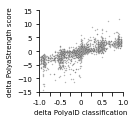

Corresponding metrics:
Pearson R- 19827 (0.71232069759148, 0.0)


In [19]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

sns.scatterplot(data = clin_repr_xte, x = 'deltaClassification', y = 'deltaStrength',
                color = 'dimgray', s = 2, alpha = 0.5, rasterized = True, ax = ax)

ax.set_xlabel("delta PolyaID classification")
ax.set_ylabel("delta PolyaStrength score")

ax.set_xlim(-1,1)
ax.set_xticks(np.arange(-1,1.01,0.25))
ax.set_xticklabels(['-1.0','','-0.5','','0','','0.5','','1.0'])

ax.set_ylim(-15,15)
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'clinvar.xte.scatter.polyaid_vs_polyastrength.delta.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print("Pearson R-", len(clin_repr_xte), st.pearsonr(clin_repr_xte['deltaClassification'], clin_repr_xte['deltaStrength']))


#### Visualize the distribution of variants around the representative test sites

In [20]:
paper_examples = ['617462','617458','617463',
                  '896666','302582','196038','1043148',
                  '35555','329889','1106650','344948']

extreme_values = []

clin_repr_xte['examples'] = np.nan
clin_repr_xte.loc[clin_repr_xte['variantID'].isin(extreme_values), 'examples'] = 'extreme'
clin_repr_xte.loc[clin_repr_xte['variantID'].isin(paper_examples), 'examples'] = 'paper'


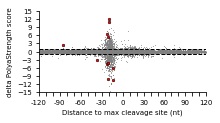

In [21]:
fig,ax = plt.subplots(1,1, figsize = (3,1.5))

ax.axhline(y = -thresh_delta, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.axhline(y = +thresh_delta, color = 'black', linestyle = 'dashed', linewidth = 1)

sns.scatterplot(data = clin_repr_xte, x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'gray', edgecolor = None, s = 1, alpha = 0.75, 
                rasterized = True, ax = ax)

sns.scatterplot(data = clin_repr_xte.loc[(clin_repr_xte['examples'] == 'extreme') & (np.abs(clin_repr_xte['deltaStrength']) >= thresh_delta)], 
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = None, s = 5, alpha = 1, 
                rasterized = True, ax = ax)

sns.scatterplot(data = clin_repr_xte.loc[(clin_repr_xte['examples'] == 'paper') & (np.abs(clin_repr_xte['deltaStrength']) >= thresh_delta)],
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = 'black', linewidth = 0.5, s = 7, alpha = 1, 
                rasterized = True, ax = ax)

ax.set_xlim(-120,120)
ax.set_xticks(np.arange(-120,121,10))
ax.set_xticklabels(['-120','','','-90','','','-60','','','-30','','','0','','','30','','','60','','','90','','','120'])

ax.set_ylim(-15,15)
ax.yaxis.set_major_locator(MultipleLocator(3))

ax.set_xlabel("Distance to max cleavage site (nt)")
ax.set_ylabel("delta PolyaStrength score")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'clinvar.xte.change_strength_by_position.prob.repr.highlight.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


In [22]:
preview_cols = ['variantID','gene','affectedMotifs','testSiteDistStranded','deltaClassification','deltaStrength','examples']
clin_repr_xte.loc[(np.abs(clin_repr_xte['deltaStrength']) >= thresh_delta) & (clin_repr_xte['variantID'].isin(paper_examples)), preview_cols].sort_values('deltaStrength')


,variantID,gene,affectedMotifs,testSiteDistStranded,deltaClassification,deltaStrength,examples
1696892,35555,TP53,disrupted_AATAAA|AATAAA,-14,-0.184303,-10.303949,paper
1866196,329889,PNKP,disrupted_AATAAA|AATAAA,-21,-0.231629,-10.270096,paper
2021396,617463,NAA10,disrupted_AATAAA|AATAAA,-14,-0.489253,-6.002276,paper
2021486,617458,NAA10,disrupted_AATAAA|AATAAA,-23,-0.271456,-4.522871,paper
2021567,617462,NAA10,disrupted_AATAAA|AATAAA,-21,-0.489524,-4.104819,paper
1286759,302582,SCN4B,"disrupted_TGTA-Rich|ATTGTA,TGTATT,TTGTAT",-37,-0.000119,-3.271526,paper
167096,896666,LRPPRC,"created_TGTA-Rich|ATTGTA,TGTATT,TTGTAT",-86,0.000004,2.263146,paper
247304,196038,SCN2A,created_AATAAA|AATAAA,-21,0.965398,5.263720,paper
363602,344948,ACVR2B,created_AATAAA|AATAAA,-23,0.510231,6.541845,paper
99457,1106650,TNNT2,created_AATAAA|AATAAA,-19,0.643895,10.966812,paper


#### Summarize the motifs affected by variants

In [23]:
clin_sum_dt = (
    assoc_xte.loc[assoc_xte['affectedMotifDirection'] != 'retained']
    [['variantID','affectedMotifDirection','affectedMotifFamily']]
    .drop_duplicates()
)

clin_sum = (clin_sum_dt
    .groupby(['affectedMotifFamily','affectedMotifDirection']).size()
    .reset_index().rename(columns = {0:'Count'})
)

clin_sum['Proportion'] = clin_sum['Count'] / clin_sum.groupby(['affectedMotifFamily'])['Count'].transform('sum')

print(clin_sum_dt.shape)
print(clin_sum_dt.variantID.nunique())
print(clin_sum['Count'].sum())


(972, 3)
969
972


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
notebook_setup.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  from sklearn.decomposition import PCA


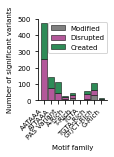

In [24]:
ordering = ['AATAAA','ATTAAA','PAS Variant','A-Rich','T-Rich','TGTA','TGTA-Rich','GT/CT-Rich','G-Rich']

modified_props  = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'modified',  ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
disrupted_props = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'disrupted', ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
created_props   = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'created',   ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)

fig,ax = plt.subplots(1,1, figsize = (1.25,1.5))

plt.bar(ordering, modified_props, label = 'Modified', color = 'gray', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, disrupted_props, bottom = modified_props, label = 'Disrupted', color = '#B3589A', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, created_props, bottom = modified_props + disrupted_props, label = 'Created', color = 'seagreen', edgecolor = 'black', linewidth = 0.5)

ax.set_xticklabels(ordering, rotation = 45, ha = 'right', va = 'top')
ax.set_xlabel("Motif family")
ax.set_ylabel("Number of significant variants")

ax.set_ylim(0,500)
ax.yaxis.set_major_locator(MultipleLocator(100))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'clinvar.xte.effect_by_family_by_direction.count.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Summarize the clinical significance of significant variants

In [25]:
sig_ordering = ['Benign','Benign/Likely_benign','Likely_benign',
                'Uncertain_significance',
                'Likely_pathogenic','Pathogenic/Likely_pathogenic','Pathogenic',
                'Conflicting_interpretations_of_pathogenicity','Other']

clin_sig = assoc_xte[['variantID','clinical_significance']].drop_duplicates()

clin_sig['clin_sig'] = 'Other'
clin_sig.loc[clin_sig['clinical_significance'].isin(sig_ordering), 'clin_sig'] = clin_sig['clinical_significance']

clin_sig_sum = clin_sig.groupby(['clin_sig']).size().loc[sig_ordering].reset_index().rename(columns = {0:'count'})
clin_sig_sum['prop']  = clin_sig_sum['count'] / clin_sig_sum['count'].sum()
clin_sig_sum['label'] = clin_sig_sum['clin_sig'] + " (" + (clin_sig_sum['prop']*100).round(2).astype(str) + "%)"

print(clin_sig.shape)
print(clin_sig.variantID.nunique())
print(clin_sig_sum['count'].sum())


(985, 3)
985
985


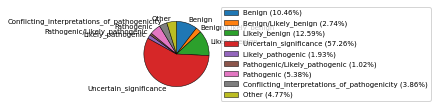

In [26]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

wedges, texts = plt.pie(clin_sig_sum['prop'], 
                        labels = clin_sig_sum['clin_sig'],
                        startangle = 90, counterclock = False,
                        wedgeprops = {'linewidth' : 0.5, 'edgecolor' : 'black'}
                       )

ax.legend(wedges, clin_sig_sum['label'],
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig(os.path.join(OUTDIR, f'clinvar.xte.clinical_significance.percent_test_sites.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Does the distribution of clinical effects change if we use more stringent cutoffs?

In [27]:
sig_ordering = ['Benign','Benign/Likely_benign','Likely_benign',
                'Uncertain_significance',
                'Likely_pathogenic','Pathogenic/Likely_pathogenic','Pathogenic',
                'Conflicting_interpretations_of_pathogenicity','Other']

clin_sig = assoc_xte[['variantID','deltaStrength','directionEffect','clinical_significance']].drop_duplicates()

clin_sig['clin_sig'] = 'Other'
clin_sig.loc[clin_sig['clinical_significance'].isin(sig_ordering), 'clin_sig'] = clin_sig['clinical_significance']

clin_sig_sum = clin_sig.groupby(['clin_sig']).size().loc[sig_ordering].reset_index().rename(columns = {0:'count'})
clin_sig_sum['prop']  = clin_sig_sum['count'] / clin_sig_sum['count'].sum()
clin_sig_sum['label'] = clin_sig_sum['clin_sig'] + " (" + (clin_sig_sum['prop']*100).round(2).astype(str) + "%)"

print(clin_sig.shape)
print(clin_sig_sum['count'].sum())
print(clin_sig_sum)


(988, 5)
988
                                       clin_sig  count      prop  \
0                                        Benign    103  0.104251   
1                          Benign/Likely_benign     27  0.027328   
2                                 Likely_benign    124  0.125506   
3                        Uncertain_significance    566  0.572874   
4                             Likely_pathogenic     19  0.019231   
5                  Pathogenic/Likely_pathogenic     10  0.010121   
6                                    Pathogenic     54  0.054656   
7  Conflicting_interpretations_of_pathogenicity     38  0.038462   
8                                         Other     47  0.047571   

                                               label  
0                                    Benign (10.43%)  
1                       Benign/Likely_benign (2.73%)  
2                             Likely_benign (12.55%)  
3                    Uncertain_significance (57.29%)  
4                          Like

In [28]:
## increasing cutoffs

cutoffs = [1.0, 1.5, 2.0, 3.0, 4.0]
clin_sig_vary = []
clin_sig_sites = []

for c in cutoffs:
    
    clin_dt = clin_sig.loc[np.abs(clin_sig['deltaStrength']) >= c]
    clin_sig_sites.append(len(clin_dt))
    
    clin_sig_sum = clin_dt.groupby(['clin_sig']).size().loc[sig_ordering].reset_index().rename(columns = {0:'count'})
    clin_sig_sum['prop']  = clin_sig_sum['count'] / clin_sig_sum['count'].sum()
    clin_sig_sum['label'] = clin_sig_sum['clin_sig'] + " (" + (clin_sig_sum['prop']*100).round(2).astype(str) + "%)"
    clin_sig_sum['cutoff'] = c
    
    clin_sig_vary.append(clin_sig_sum)
    
clin_sig_vary = (
    pd.concat(clin_sig_vary, ignore_index = True, sort = False)
    .pivot(index = 'clin_sig', columns = 'cutoff', values = 'prop')
)
print(clin_sig_vary.round(2))

cutoff                                         1.0   1.5   2.0   3.0   4.0
clin_sig                                                                  
Benign                                        0.10  0.11  0.11  0.14  0.11
Benign/Likely_benign                          0.03  0.02  0.03  0.03  0.03
Conflicting_interpretations_of_pathogenicity  0.04  0.04  0.04  0.04  0.04
Likely_benign                                 0.13  0.13  0.13  0.13  0.14
Likely_pathogenic                             0.02  0.02  0.02  0.02  0.02
Other                                         0.05  0.03  0.03  0.02  0.01
Pathogenic                                    0.05  0.06  0.06  0.07  0.10
Pathogenic/Likely_pathogenic                  0.01  0.01  0.01  0.01  0.01
Uncertain_significance                        0.57  0.58  0.58  0.53  0.54


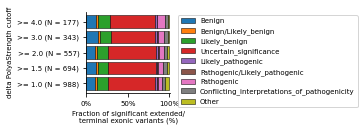

In [29]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

ys = list(range(len(cutoffs)))
sums = [0]*len(cutoffs)

for s in sig_ordering:
    
    widths = clin_sig_vary.loc[s].to_numpy().flatten() * 100
    ax.barh(ys, widths, left = sums, edgecolor = 'black', linewidth = 0.5, label = s)
    
    for i,w in enumerate(widths):
        sums[i] += w
        
ax.set_xlabel("Fraction of significant extended/\nterminal exonic variants (%)")
ax.set_xlim(0,101)
ax.xaxis.set_major_formatter(PercentFormatter())

ax.set_ylabel("delta PolyaStrength cutoff")
ax.set_yticks(ys)
ax.set_yticklabels([f'>= {c} (N = {n})' for c,n in zip(cutoffs,clin_sig_sites)])
        
ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'clinvar.xte.clinical_significance.percent_test_sites.by_cutoff.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


### Variants affecting intronic sites

#### Visualize the distribution of variants around the representative test sites

In [30]:
paper_examples = ['1248002']
extreme_values = ['1281655','125744','1243139','1271412',
                  '746304','1126993','915624','335197']

clin_repr_int['examples'] = np.nan
clin_repr_int.loc[clin_repr_int['variantID'].isin(extreme_values), 'examples'] = 'extreme'
clin_repr_int.loc[clin_repr_int['variantID'].isin(paper_examples), 'examples'] = 'paper'


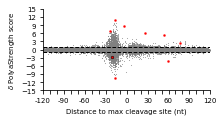

In [31]:
fig,ax = plt.subplots(1,1, figsize = (3,1.5))

ax.axhline(y = -thresh_delta, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.axhline(y = +thresh_delta, color = 'black', linestyle = 'dashed', linewidth = 1)

sns.scatterplot(data = clin_repr_int, x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'gray', edgecolor = None, s = 1, alpha = 0.75, 
                rasterized = True, ax = ax)

sns.scatterplot(data = clin_repr_int.loc[(clin_repr_int['examples'] == 'extreme') & (np.abs(clin_repr_int['deltaStrength']) >= thresh_delta)], 
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = None, s = 5, alpha = 1, 
                rasterized = True, ax = ax)

sns.scatterplot(data = clin_repr_int.loc[(clin_repr_int['examples'] == 'paper') & (np.abs(clin_repr_int['deltaStrength']) >= thresh_delta)],
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = 'black', linewidth = 0.5, s = 7, alpha = 1, 
                rasterized = True, ax = ax)

ax.set_xlim(-120,120)
ax.set_xticks(np.arange(-120,121,10))
ax.set_xticklabels(['-120','','','-90','','','-60','','','-30','','','0','','','30','','','60','','','90','','','120'])

ax.set_ylim(-15,15)
ax.yaxis.set_major_locator(MultipleLocator(3))

ax.set_xlabel("Distance to max cleavage site (nt)")
ax.set_ylabel(r'$\delta$' + " PolyaStrength score")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'clinvar.int.change_strength_by_position.prob.repr.highlight.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


In [32]:
preview_cols = ['variantID','gene','affectedMotifs','testSiteDistStranded','deltaClassification','deltaStrength','examples']
clin_repr_int.loc[(np.abs(clin_repr_int['deltaStrength']) >= thresh_delta) & (clin_repr_int['variantID'].isin(paper_examples)), preview_cols].sort_values('deltaStrength')


,variantID,gene,affectedMotifs,testSiteDistStranded,deltaClassification,deltaStrength,examples
7250917,1248002,RUNX1,disrupted_AATAAA|AATAAA,-21,-0.091454,-2.742887,paper


In [33]:
preview_cols = ['variantID','gene','affectedMotifs','testSiteDistStranded','deltaClassification','deltaStrength']
clin_repr_int.loc[(np.abs(clin_repr_int['deltaStrength']) >= thresh_delta) & (clin_repr_int['variantID'].isin(extreme_values)), preview_cols].sort_values('deltaStrength')


,variantID,gene,affectedMotifs,testSiteDistStranded,deltaClassification,deltaStrength
3121047,335197,NDUFA10,disrupted_AATAAA|AATAAA,-17,-0.443446,-10.610767
6424765,1281655,VPS13C,"modified_GT/CT-Rich|TGTGTT,GTGTGT,GTGTTT,TGTGTG",59,-0.000005,-4.287689
6499247,1126993,TSC2,"modified_GT/CT-Rich|GTGTGC,TGTGTT,CTGTGT,CGTGT...",77,0.036078,2.451655
2789926,746304,LRP2,"modified_T-Rich|TTCTTT,TTTTTC,TTTTTA,TTTCTT,TT...",54,-0.000212,5.194749
6758932,125744,BRCA1,"disrupted_GT/CT-Rich|TCTGCT,CTCTGC",27,0.262961,6.033232
6381031,915624,FBN1,created_AATAAA|AATAAA,-24,0.202596,6.974663
4072067,1243139,PKHD1,created_AATAAA|AATAAA,-4,0.966113,8.523732
3159731,1271412,KAT2B,created_AATAAA|AATAAA,-17,0.897484,10.965423


#### Summarize the motifs affected by variants

In [34]:
clin_sum_dt = (
    assoc_int.loc[assoc_int['affectedMotifDirection'] != 'retained']
    [['variantID','affectedMotifDirection','affectedMotifFamily']]
    .drop_duplicates()
)

clin_sum = (clin_sum_dt
    .groupby(['affectedMotifFamily','affectedMotifDirection']).size()
    .reset_index().rename(columns = {0:'Count'})
)

clin_sum['Proportion'] = clin_sum['Count'] / clin_sum.groupby(['affectedMotifFamily'])['Count'].transform('sum')

print(clin_sum_dt.shape)
print(clin_sum_dt.variantID.nunique())
print(clin_sum['Count'].sum())


(434, 3)
434
434


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
notebook_setup.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  from sklearn.decomposition import PCA


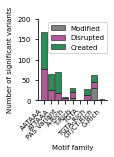

In [35]:
ordering = ['AATAAA','ATTAAA','PAS Variant','A-Rich','T-Rich','TGTA','TGTA-Rich','GT/CT-Rich','G-Rich']

modified_props  = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'modified',  ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
disrupted_props = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'disrupted', ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
created_props   = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'created',   ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)

fig,ax = plt.subplots(1,1, figsize = (1.25,1.5))

plt.bar(ordering, modified_props, label = 'Modified', color = 'gray', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, disrupted_props, bottom = modified_props, label = 'Disrupted', color = '#B3589A', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, created_props, bottom = modified_props + disrupted_props, label = 'Created', color = 'seagreen', edgecolor = 'black', linewidth = 0.5)

ax.set_xticklabels(ordering, rotation = 45, ha = 'right', va = 'top')
ax.set_xlabel("Motif family")
ax.set_ylabel("Number of significant variants")

ax.set_ylim(0,200)
ax.yaxis.set_major_locator(MultipleLocator(50))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'clinvar.int.effect_by_family_by_direction.count.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Summarize the clinical significance of significant variants

In [36]:
sig_ordering = ['Benign','Benign/Likely_benign','Likely_benign',
                'Uncertain_significance',
                'Likely_pathogenic','Pathogenic/Likely_pathogenic','Pathogenic',
                'Conflicting_interpretations_of_pathogenicity','Other']

clin_sig = assoc_int[['variantID','clinical_significance']].drop_duplicates()

clin_sig['clin_sig'] = 'Other'
clin_sig.loc[clin_sig['clinical_significance'].isin(sig_ordering), 'clin_sig'] = clin_sig['clinical_significance']

clin_sig_sum = clin_sig.groupby(['clin_sig']).size().loc[sig_ordering].reset_index().rename(columns = {0:'count'})
clin_sig_sum['prop']  = clin_sig_sum['count'] / clin_sig_sum['count'].sum()
clin_sig_sum['label'] = clin_sig_sum['clin_sig'] + " (" + (clin_sig_sum['prop']*100).round(2).astype(str) + "%)"

print(clin_sig.shape)
print(clin_sig_sum['count'].sum())


(441, 3)
441


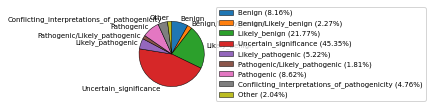

Corresponding data:
                                       clin_sig  count      prop
0                                        Benign     36  0.081633
1                          Benign/Likely_benign     10  0.022676
2                                 Likely_benign     96  0.217687
3                        Uncertain_significance    200  0.453515
4                             Likely_pathogenic     23  0.052154
5                  Pathogenic/Likely_pathogenic      8  0.018141
6                                    Pathogenic     38  0.086168
7  Conflicting_interpretations_of_pathogenicity     21  0.047619
8                                         Other      9  0.020408


In [37]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

wedges, texts = plt.pie(clin_sig_sum['prop'], 
                        labels = clin_sig_sum['clin_sig'],
                        startangle = 90, counterclock = False,
                        wedgeprops = {'linewidth' : 0.5, 'edgecolor' : 'black'}
                       )

ax.legend(wedges, clin_sig_sum['label'],
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig(os.path.join(OUTDIR, f'clinvar.int.clinical_significance.percent_test_sites.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(clin_sig_sum[['clin_sig','count','prop']])


#### Examples of disease-relevant variants and genes


##########
NAA10

Associated conditions-	 Microphthalmia_syndromic_1 

1
variantID                                    617462
chrom                                             X
position                                  153929948
strand                                            -
reference                                         T
alternate                                         C
gene                                          NAA10
geneStrand                                        -
affectedMotif                disrupted_AATAAA_NAA10
positionTest                              153929927
testSiteDistStranded                            -21
referenceFeature                      terminal_exon
referenceClassprob                         0.999657
alternateClassprob                         0.510133
deltaClassification                       -0.489524
referenceStrength                           2.53946
alternateStrength                          -1.56536
deltaStrength                             

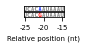


##########
NAA10

Associated conditions-	 Microphthalmia_syndromic_1 

2
variantID                                                      617458
chrom                                                               X
position                                                    153929947
strand                                                              -
reference                                                           T
alternate                                                           C
gene                                                            NAA10
geneStrand                                                          -
affectedMotif                                  disrupted_AATAAA_NAA10
positionTest                                                153929924
testSiteDistStranded                                              -23
referenceFeature                                        terminal_exon
referenceClassprob                                           0.999817
alternateClasspr

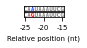


##########
NAA10

Associated conditions-	 Microphthalmia_syndromic_1 

1
variantID                                    617463
chrom                                             X
position                                  153929944
strand                                            -
reference                                         T
alternate                                         C
gene                                          NAA10
geneStrand                                        -
affectedMotif                disrupted_AATAAA_NAA10
positionTest                              153929930
testSiteDistStranded                            -14
referenceFeature                      terminal_exon
referenceClassprob                         0.999722
alternateClassprob                         0.510469
deltaClassification                       -0.489253
referenceStrength                           2.87088
alternateStrength                           -3.1314
deltaStrength                             

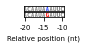


##########
LRPPRC

Associated conditions-	 Congenital_lactic_acidosis_Saguenay-Lac-Saint-Jean_type 

1
variantID                                                           896666
chrom                                                                    2
position                                                          43886311
strand                                                                   -
reference                                                                T
alternate                                                                A
gene                                                                LRPPRC
geneStrand                                                               -
affectedMotif                                        created_ATTGTA_LRPPRC
positionTest                                                      43886225
testSiteDistStranded                                                   -86
referenceFeature                                             terminal_e

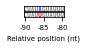


##########
SCN4B

Associated conditions-	 Congenital_long_QT_syndrome
			Long_QT_syndrome 

2
variantID                                                  302582
chrom                                                          11
position                                                118133415
strand                                                          -
reference                                                  AAATAC
alternate                                                       A
gene                                                        SCN4B
geneStrand                                                      -
affectedMotif                              disrupted_ATTGTA_SCN4B
positionTest                                            118133378
testSiteDistStranded                                          -37
referenceFeature                                    terminal_exon
referenceClassprob                                       0.999498
alternateClassprob                             

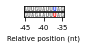


##########
SCN2A

Associated conditions-	 Early_infantile_epileptic_encephalopathy_11
			Seizures_benign_familial_infantile_3 

4
variantID                                                      196038
chrom                                                               2
position                                                    165389311
strand                                                              +
reference                                                           C
alternate                                                           T
gene                                                            SCN2A
geneStrand                                                          +
affectedMotif                                    created_AATAAA_SCN2A
positionTest                                                165389333
testSiteDistStranded                                              -21
referenceFeature                                        terminal_exon
referenceClassprob           

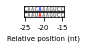


##########
PLEC

Associated conditions-	 Epidermolysis_bullosa_simplex_Ogna_type
			Epidermolysis_bullosa_simplex_with_muscular_dystrophy
			Epidermolysis_bullosa_simplex_with_nail_dystrophy
			Epidermolysis_bullosa_simplex_with_pyloric_atresia
			Limb-girdle_muscular_dystrophy_type_2Q 

5
variantID                                                1043148
chrom                                                          8
position                                               143920686
strand                                                         -
reference                                                      C
alternate                                                      A
gene                                                        PLEC
geneStrand                                                     -
affectedMotif                                created_AATAAA_PLEC
positionTest                                           143920666
testSiteDistStranded                                      

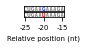


##########
TP53

Associated conditions-	 Basal_cell_carcinoma_susceptibility_to_7
			Hereditary_cancer-predisposing_syndrome
			Li-Fraumeni_syndrome_1 

3
variantID                                                       35555
chrom                                                              17
position                                                      7668434
strand                                                              -
reference                                                           T
alternate                                                           G
gene                                                             TP53
geneStrand                                                          -
affectedMotif                                   disrupted_AATAAA_TP53
positionTest                                                  7668420
testSiteDistStranded                                              -14
referenceFeature                                        terminal_exon
refe

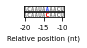


##########
PNKP

Associated conditions-	 Early_infantile_epileptic_encephalopathy_10 

1
variantID                                                     329889
chrom                                                             19
position                                                    49861225
strand                                                             -
reference                                                          T
alternate                                                          G
gene                                                            PNKP
geneStrand                                                         -
affectedMotif                                 disrupted_TTTATT_PTOV1
positionTest                                                49861204
testSiteDistStranded                                             -21
referenceFeature                                       terminal_exon
referenceClassprob                                          0.999944
alternateClas

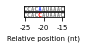


##########
RUNX1

Associated conditions-	 Familial_platelet_disorder_with_associated_myeloid_malignancy 

1
variantID                                                           934627
chrom                                                                   21
position                                                          34892925
strand                                                                   -
reference                                                                C
alternate                                                                A
gene                                                                 RUNX1
geneStrand                                                               -
affectedMotif                                         created_CTGTAT_RUNX1
positionTest                                                      34892876
testSiteDistStranded                                                   -49
referenceFeature                                          intron:c

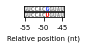


##########
TNNT2

Associated conditions-	 Familial_hypertrophic_cardiomyopathy_2
			Familial_restrictive_cardiomyopathy_3
			Left_ventricular_noncompaction_6 

3
variantID                                               1106650
chrom                                                         1
position                                              201359210
strand                                                        -
reference                                                     C
alternate                                                     T
gene                                                      TNNT2
geneStrand                                                    -
affectedMotif                              created_AATAAA_TNNT2
positionTest                                          201359191
testSiteDistStranded                                        -19
referenceFeature                                  terminal_exon
referenceClassprob                                     0.355098
alter

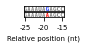


##########
ACVR2B

Associated conditions-	 Heterotaxia 

1
variantID                                344948
chrom                                         3
position                               38484904
strand                                        +
reference                               TAGAGAA
alternate                                     T
gene                                     ACVR2B
geneStrand                                    +
affectedMotif             created_AATAAA_ACVR2B
positionTest                           38484933
testSiteDistStranded                        -23
referenceFeature                  terminal_exon
referenceClassprob                     0.488345
alternateClassprob                     0.998576
deltaClassification                    0.510231
referenceStrength                      -6.48093
alternateStrength                     0.0609178
deltaStrength                           6.54184
referenceStrengthProb                 0.0110716
alternateStrengthProb       

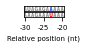

In [38]:
example_cols = ['variantID', 'chrom', 'position', 'strand', 'reference', 'alternate',
                'gene', 'geneStrand', 'affectedMotif', 'positionTest', 'testSiteDistStranded','referenceFeature',
                'referenceClassprob', 'alternateClassprob','deltaClassification',
                'referenceStrength', 'alternateStrength', 'deltaStrength',
                'referenceStrengthProb', 'alternateStrengthProb', 'deltaStrengthProb',
                'referenceICprob', 'alternateICprob', 'referenceISprob', 'alternateISprob',
                'affectedMotifs', 'condition',
                'clinical_significance']

example_ids = ['617462','617458','617463','896666','302582','196038','1043148','35555','329889','934627','1106650','344948']
example_gene = ['NAA10','NAA10','NAA10','LRPPRC','SCN4B','SCN2A','PLEC','TP53','PNKP','RUNX1','TNNT2','ACVR2B']
example_range = [(120-25,120-15+1),(120-25,120-15+1),(120-20,120-10+1),(120-90,120-80+1),(120-45, 120-35+1),(120-25, 120-15+1),(120-25, 120-15+1),(120-20, 120-10+1),(120-25, 120-15+1),(120-55, 120-45+1),(120-25, 120-15+1),(120-30, 120-20+1)]

for eid, egene, erange in zip(example_ids, example_gene, example_range):
    print(f"\n##########\n{egene}")
    print("\nAssociated conditions-\t", "\n\t\t\t".join(sorted(set(clin_filt_long.loc[(clin_filt_long['variantID'] == eid) & (~clin_filt_long['condition'].isin(['not_provided','not_specified'])), 'condition'].tolist()))), "\n")
    print((clin_filt_long['variantID'] == eid).sum())
    print(clin_filt_long.loc[clin_filt_long['variantID'] == eid].iloc[0][example_cols])
    
    e_name = f'clinvar.{eid}.{egene}'
    e_data = clin_filt_long.loc[(clin_filt_long['variantID'] == eid) & (clin_filt_long['gene'] == egene)].iloc[0]

    genetics.plot_variant_logo(os.path.join(OUTDIR, f'variant_examples.clinvar.{e_name}.svg'),
                               e_data['referenceSequence'], e_data['alternateSequence'], 
                               erange, [120+e_data['testSiteDistStranded']])
    

## Benchmark Examples

In [39]:
benchmark_cols = ['variantID', 'chrom', 'position', 'strand', 'reference', 'alternate',
                  'gene', 'geneStrand', 'affectedMotif', 'positionTest', 'testSiteDistStranded','referenceFeature',
                  'referenceClassprob', 'alternateClassprob','deltaClassification',
                  'referenceStrength', 'alternateStrength', 'deltaStrength',
                  'referenceStrengthProb', 'alternateStrengthProb', 'deltaStrengthProb',
                  'referenceICprob', 'alternateICprob', 'referenceISprob', 'alternateISprob',
                  'readsExact', 'readsSlop', 'directionEffect', 'affectedMotifs', 'condition',
                  'clinical_significance']

benchmark_ids = ['35555', '375749', '15647','65581']
benchmark_gene = ['TP53','HBA2v1','HBA2v2','INS']

for bid, bgene in zip(benchmark_ids, benchmark_gene):
    print(f"\n##########\n{bgene}")
    print("\nAssociated conditions-\t", "\n\t\t\t".join(sorted(set(clin_filt_long.loc[clin_filt_long['variantID'] == bid, 'condition'].tolist()))), "\n")
    print(clin_filt_long.loc[clin_filt_long['variantID'] == bid].iloc[0][benchmark_cols])
    


##########
TP53

Associated conditions-	 Basal_cell_carcinoma_susceptibility_to_7
			Hereditary_cancer-predisposing_syndrome
			Li-Fraumeni_syndrome_1 

variantID                                                       35555
chrom                                                              17
position                                                      7668434
strand                                                              -
reference                                                           T
alternate                                                           G
gene                                                             TP53
geneStrand                                                          -
affectedMotif                                   disrupted_AATAAA_TP53
positionTest                                                  7668420
testSiteDistStranded                                              -14
referenceFeature                                        terminal_exon
refere

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
